# Masks and Filters in Biomedical Image Analysis


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import imageio

plt.rcParams['figure.figsize'] = (10, 8)

In [2]:
def format_and_render_plot():
    '''Custom function to simplify common formatting operations for exercises. Operations include: 
    1. Turning off axis grids.
    2. Calling `plt.tight_layout` to improve subplot spacing.
    3. Calling `plt.show()` to render plot.'''
    fig = plt.gcf()
    for ax in fig.axes:
        ax.axis('off')    
    plt.tight_layout()
    plt.show()

## Image intensities
- Pixels and voxels
    - Pixel: 2D picture elements
    - Voxel: 3D volume elements
- Histograms
    - Count number of pixels at each intensity value
- Equalization
    - Distributions often skewed toward low intensity (background values)
    - Redistribute values to optimize full intensity range
    
    
### Intensity
In this chapter, we will work with a hand [radiograph](https://en.wikipedia.org/wiki/Radiography) from a 2017 [Radiological Society of North America competition](http://rsnachallenges.cloudapp.net/competitions/4). X-ray absorption is highest in dense tissue such as bone, so the resulting intensities should be high. Consequently, images like this can be used to predict "bone age" in children.

To start, let's load the image and check its intensity range.

The image datatype determines the range of possible intensities: e.g., 8-bit unsigned integers (`uint8`) can take values in the range of 0 to 255. A colorbar can be helpful for connecting these values to the visualized image.

Data type: uint8
Min. value: 3
Max value: 224


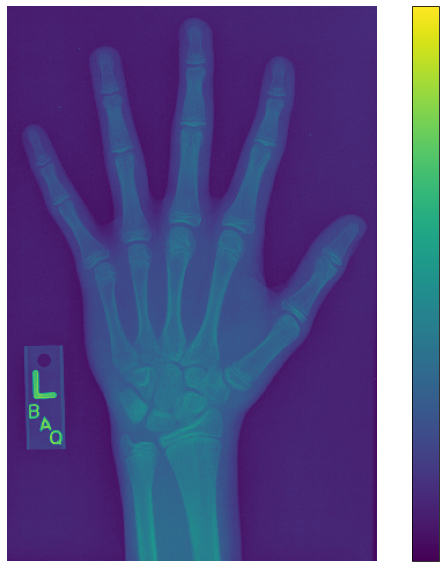

In [3]:
# Load the hand radiograph
im = imageio.imread('./dataset/hand.png')
print('Data type:', im.dtype)
print('Min. value:', im.min())
print('Max value:', im.max())

# Plot the grayscale image
plt.imshow(im, vmin=0, vmax=255)
plt.colorbar()
format_and_render_plot()

### Histograms
**Histograms** display the distribution of values in your image by binning each element by its intensity then measuring the size of each bin.

The area under a histogram is called the **cumulative distribution function** (CDF for short). It measures the frequency with which a given range of pixel intensities occurs.

For this exercise, describe the intensity distribution in im by calculating the histogram and cumulative distribution function and displaying them together.

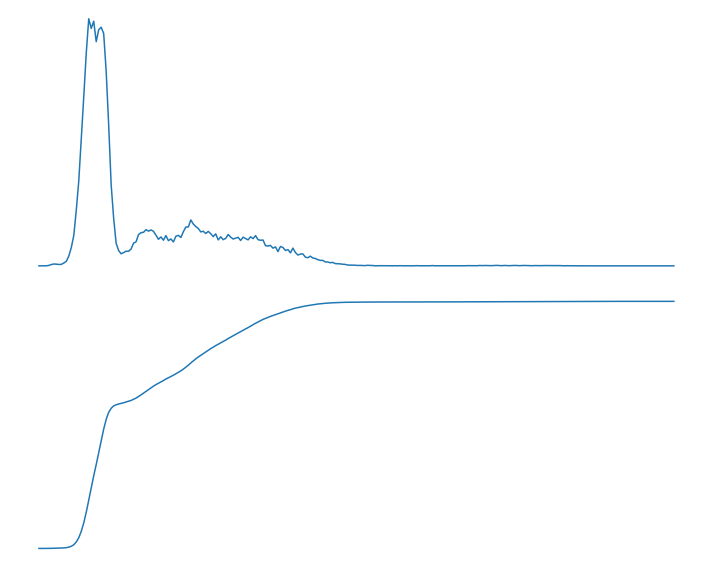

In [4]:
import scipy.ndimage as ndi

# Create a histogram, binned at each possible value
hist = ndi.histogram(im, min=0, max=255, bins=256)

# Create a cumulative distribution function
cdf = hist.cumsum() / hist.sum()

# Plot the histogram and CDF
fig, axes = plt.subplots(2, 1, sharex=True)
axes[0].plot(hist, label='Histogram');
axes[1].plot(cdf, label='CDF');
format_and_render_plot();


You can see the data is clumped into a few separate distributions, consisting of background noise, skin, bone, and artifacts. Sometimes we can separate these well with global thresholds (foreground/background); other times the distributions overlap quite a bit (skin/bone).

## Masks
### Create a mask
Masks are the primary method for removing or selecting specific parts of an image. They are binary arrays that indicate whether a value should be included in an analysis. Typically, masks are created by applying one or more logical operations to an image.

For this exercise, try to use a simple intensity threshold to differentiate between skin and bone in the hand radiograph.

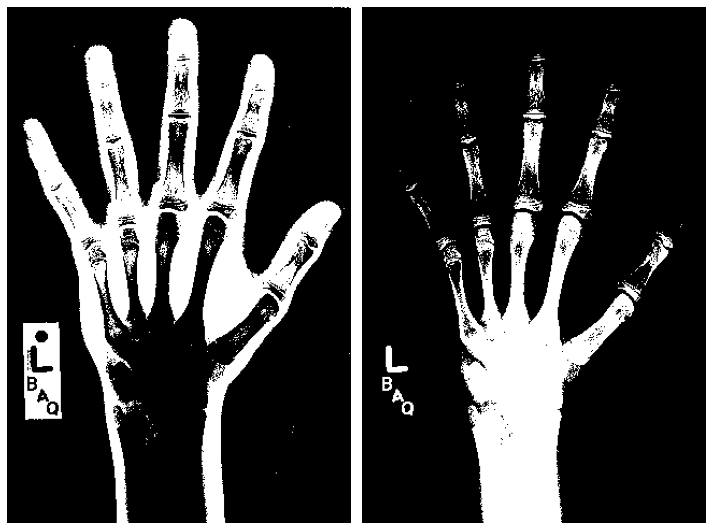

In [5]:
# Create skin and bone masks
mask_bone = im >= 75
mask_skin = (im >= 35) & (im < 75)

# Plot the skin (0) and bone (1) masks
fig, axes = plt.subplots(1, 2)
axes[0].imshow(mask_skin, cmap='gray')
axes[1].imshow(mask_bone, cmap='gray')
format_and_render_plot()

### Apply a mask
Although masks are binary, they can be applied to images to filter out pixels where the mask is `False`.

NumPy's `where()` function is a flexible way of applying masks. It takes three arguments:
```python
np.where(condition, x, y)
```

`condition`, `x` and `y` can be either arrays or single values. This allows you to pass through original image values while setting masked values to 0.

Let's practice applying masks by selecting the bone-like pixels from the hand x-ray (`im`).

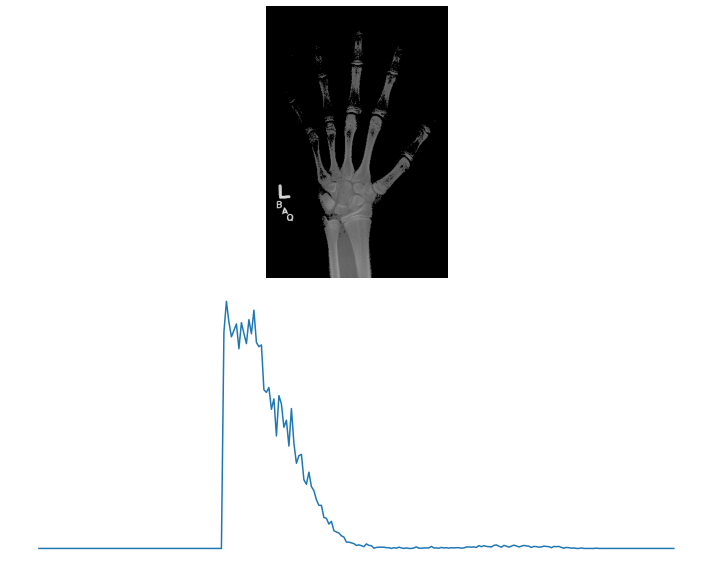

In [6]:
# Screen out non-bone pixels from "im"
mask_bone = im >= 75
im_bone = np.where(mask_bone, im, 0)

# Get the histogram of bone intensity
hist = ndi.histogram(im_bone, min=1, max=255, bins=255)

# Plot masked image and histogram
fig, axes = plt.subplots(2, 1)
axes[0].imshow(im_bone, cmap='gray')
axes[1].plot(hist)
format_and_render_plot()

### Tune a mask
Imperfect masks can be tuned through the addition and subtraction of pixels. SciPy includes several useful methods for accomplishing these ends. These include:

- `binary_dilation`: Add pixels along edges
- `binary_erosion`: Remove pixels along edges
- `binary_opening`: Erode then dilate, "opening" areas near edges
- `binary_closing`: Dilate then erode, "filling in" holes

For this exercise, create a bone mask then tune it to include additional pixels.

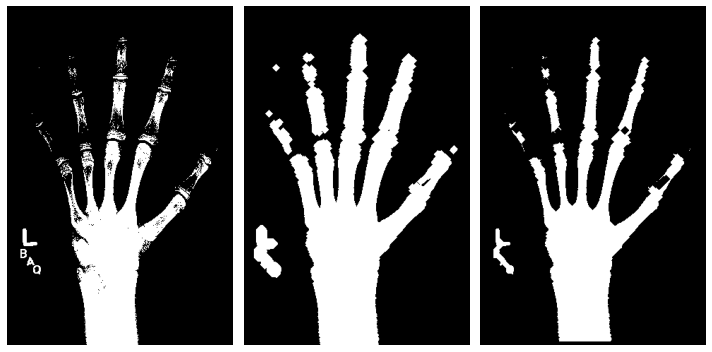

In [7]:
# Create and tune bone mask
mask_bone = im >= 75
mask_dilate = ndi.binary_dilation(mask_bone, iterations=5)
mask_closed = ndi.binary_closing(mask_bone, iterations=5)

# Plot masked images
fig, axes = plt.subplots(1, 3)
axes[0].imshow(mask_bone, cmap='gray')
axes[1].imshow(mask_dilate, cmap='gray')
axes[2].imshow(mask_closed, cmap='gray')
format_and_render_plot()

## Filters
- Convolution with a sharpening filter
![conv](dataset/conv_sharpening.png)

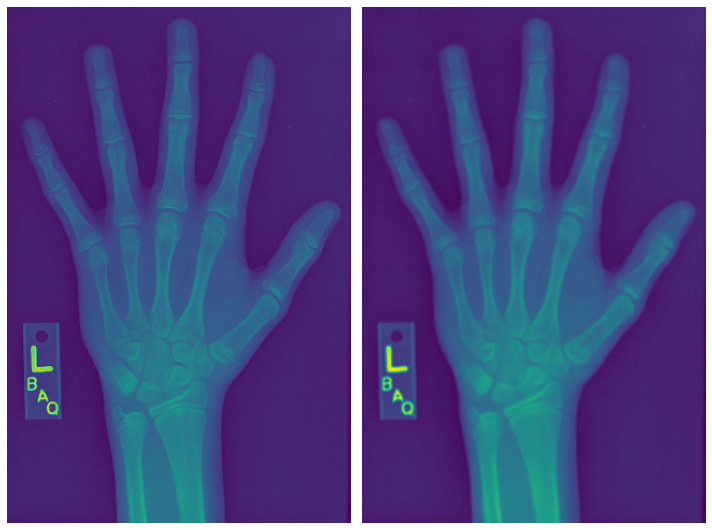

In [8]:
# Set filter weights
weights = [[0.11, 0.11, 0.11],
           [0.11, 0.11, 0.11], 
           [0.11, 0.11, 0.11]]

# Convolve the image with the filter
im_filt = ndi.convolve(im, weights)

# Plot the images
fig, axes = plt.subplots(1, 2)
axes[0].imshow(im)
axes[1].imshow(im_filt)
format_and_render_plot()

Filter functions
Convolutions rely on a set of weights, but filtering can also be done using functions such as the mean, median and maximum. Just like with convolutions, filter functions will update each pixel value based on its local neighborhood.

Consider the following lines of code

```python
assert im_filt[1,1] == 49```


Which of the following statements should go in the blank so that the assert statement evaluates to True?

In [9]:
im = np.array([[93, 36,  87], 
               [18, 49,  51],
               [45, 32,  63]])

im_filt = ndi.convolve(im, weights)


In [10]:
im_filt[1,1]==49

False

In [11]:
im1 =ndi.maximum_filter(im, size=3)

In [12]:
im1[1,1] == 49

False

In [13]:
im2 = ndi.uniform_filter(im, size=3)

In [14]:
im2[1,1] == 49

False

In [15]:
im3=ndi.percentile_filter(im, 60, size=3)

In [16]:
im3[1,1] == 49

False

In [17]:
im4= ndi.median_filter(im, size=3)

In [18]:
im4[1,1] == 49

True

### Smoothing
Smoothing can improve the [signal-to-noise ratio](https://en.wikipedia.org/wiki/Signal-to-noise_ratio)(SNR for short) of your image by blurring out small variations in intensity. The Gaussian filter is excellent for this: it is a circular (or spherical) smoothing kernel that weights nearby pixels higher than distant ones.

![gaussian](dataset/Ch2_L2_Gaussian1D.png)

The width of the distribution is controlled by the sigma argument, with higher values leading to larger smoothing effects.

For this exercise, test the effects of applying Gaussian filters to the foot x-ray before creating a bone mask.


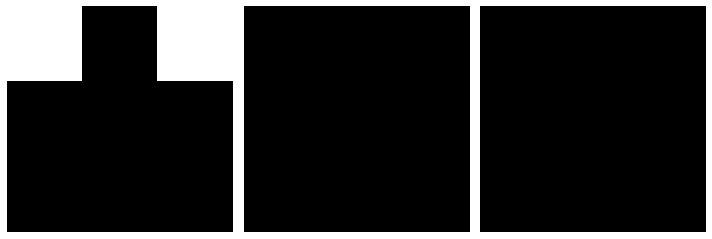

In [19]:
# Smooth "im" with Gaussian filters
im_s1 = ndi.gaussian_filter(im, sigma=1)
im_s3 = ndi.gaussian_filter(im, sigma=3)

# Draw bone masks of each image
fig, axes = plt.subplots(1, 3)
axes[0].imshow(im >= 75, cmap='gray')
axes[1].imshow(im_s1 >= 75, cmap='gray')
axes[2].imshow(im_s3 >= 75, cmap='gray')
format_and_render_plot()

## Feature detection
### Detect edges 
Filters can also be used as "detectors." If a part of the image fits the weighting pattern, the returned value will be very high (or very low).

In the case of edge detection, that pattern is a change in intensity along a plane. A filter detecting horizontal edges might look like this:
```python
weights = [[+1, +1, +1],
           [ 0,  0,  0],
           [-1, -1, -1]]
```

For this exercise, create a vertical edge detector and see how well it performs on the hand x-ray (im).


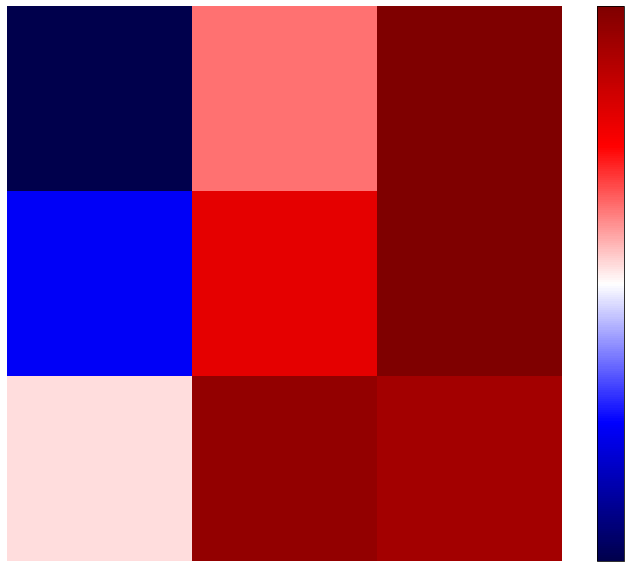

In [20]:
# Set weights to detect vertical edges
weights = [[1, 0, -1], [1, 0, -1], [1, 0, -1]]

# Convolve "im" with filter weights
edges = ndi.convolve(im, weights)

# Draw the image in color
plt.imshow(edges, cmap='seismic', vmin=-75, vmax=75);
plt.colorbar();
format_and_render_plot();

### Detect edges (2)
Edge detection can be performed along multiple axes, then combined into a single edge value. For 2D images, the horizontal and vertical "edge maps" can be combined using the Pythagorean theorem:

$$ z = \sqrt{x^2 + y^2} $$

One popular edge detector is the [Sobel filter](https://en.wikipedia.org/wiki/Sobel_operator). The Sobel filter provides extra weight to the center pixels of the detector:
```python
weights = [[ 1,  2,  1], 
           [ 0,  0,  0],
           [-1, -2, -1]]
```
For this exercise, improve upon your previous detection effort by merging the results of two Sobel-filtered images into a composite edge map.

In [21]:
# Apply Sobel filter along both axes
sobel_ax0 = ndi.sobel(im, axis=0)
sobel_ax1 = ndi.sobel(im, axis=1)

# Calculate edge magnitude 
edges = np.sqrt(np.square(sobel_ax0) + np.square(sobel_ax1))

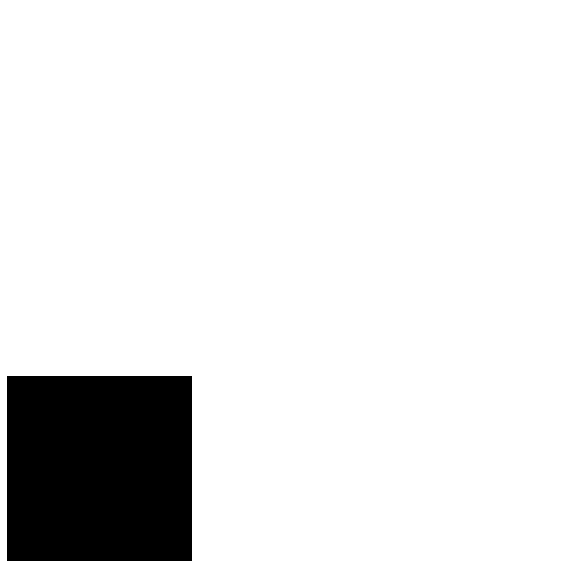

In [22]:
# Plot edge magnitude
plt.imshow(edges, cmap='gray', vmax=75)
format_and_render_plot()